In [12]:
%config IPCompleter.use_jedi = False
from hooknet.configuration.config import create_hooknet
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.samplers.utils import plot_mask
from wholeslidedata.samplers.utils import fit_data
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import time
from pprint import pprint
from creationism.utils import open_yaml
from tqdm.notebook import tqdm
from tensorflow import keras
import numpy as np

# Tiger colors
rgbas = [[0, 0, 0, 0], [0, 224, 249, 255], [0, 249, 50, 255], [174, 249, 0, 255], [249, 100, 0, 255], [249, 0, 125, 255], [149, 0, 249, 255], [0, 0, 206, 255], [0, 185, 206, 255], [0, 206, 41, 255], [143, 206, 0, 255], [206, 82, 0, 255], [206, 0, 103, 255], [124, 0, 206, 255], [0, 0, 162, 255], [0, 145, 162, 255], [0, 162, 32, 255], [114, 162, 0, 255], [162, 65, 0, 255], [162, 0, 81, 255], [97, 0, 162, 255], [0, 0, 119, 255], [0, 107, 119, 255], [0, 119, 23, 255], [83, 119, 0, 255], [119, 47, 0, 255], [119, 0, 59, 255], [71, 0, 119, 255], [100, 100, 249, 255], [100, 234, 249, 255]]
color_map = ['#{:02x}{:02x}{:02x}'.format(*rgbas[value]) for value in range(8)]

def plot_inference(patch, ground_truth, prediction):
    fig, axes = plt.subplots(1,3, figsize=(10,10))
    axes[0].imshow(patch)
    plot_mask(ground_truth, axes=axes[1], color_values=color_map)
    plot_mask(prediction, axes=axes[2], color_values=color_map)
    plt.show()

# batch iterator + hooknet config
user_config = './user_config.yml'

# number of cpus used to extract patches on multiple cores
cpus = 8
    

# HookNet

![](hooknet_software.png)

### Paper 
https://reader.elsevier.com/reader/sd/pii/S1361841520302541?token=F9D1CECE6F01CA30F95D5A689B220EB686CD10E1D2EC00773E14E08B5C3B07486080035E90A1EAC07A0A7214D59C568A&originRegion=eu-west-1&originCreation=20220126105102

In [ ]:
# !pip3 install hooknet

# Training 

In [ ]:
mode = 'training'

In [ ]:
model = create_hooknet(user_config, mode=mode)

In [5]:
with create_batch_iterator(mode=mode, user_config=user_config, cpus=cpus) as training_batch_iterator:
    pprint(training_batch_iterator.dataset.annotations_per_label_per_key)

{'100B': {'healthy glands': 14,
          'inflamed stroma': 0,
          'invasive tumor': 2,
          'necrosis not in-situ': 0,
          'rest': 4,
          'roi': 3,
          'tumor-associated stroma': 6},
 'TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297': {'healthy glands': 0,
                                                                  'inflamed stroma': 17,
                                                                  'invasive tumor': 64,
                                                                  'necrosis not in-situ': 1,
                                                                  'rest': 7,
                                                                  'roi': 1,
                                                                  'tumor-associated stroma': 38},
 'TC_S01_P000003_C0001_B104': {'healthy glands': 0,
                               'inflamed stroma': 1,
                               'invasive tumor': 4,
                     

  0%|          | 0/200 [00:00<?, ?it/s]

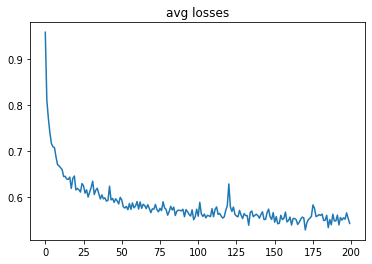

In [13]:
avg_losses = []
repeats = 200
batches = 200
with create_batch_iterator(mode=mode, user_config=user_config, cpus=cpus) as training_iterator:
    for _ in tqdm(range(repeats)):
        losses = []
        for _ in range(batches):
            x_batch, y_batch, info = next(training_iterator)
            # transpose batchsize and patches
            x_batch = list(x_batch.transpose(1,0,2,3,4))
            y_batch = y_batch.transpose(1,0,2,3,4)
            out = model.train_on_batch(x=x_batch, y=y_batch, return_dict=True)
            losses.append(out['loss'])
        avg_losses.append(np.mean(losses))

        
model.save_weights('./hooknet_weights.h5')
keras.backend.clear_session()
plt.title('avg losses')
plt.plot(avg_losses)
plt.show()

# Inference

In [10]:
mode = 'inference'

In [ ]:
model = create_hooknet(mode=mode, user_config=user_config)

In [8]:
with create_batch_iterator(mode=mode, user_config=user_config, cpus=cpus) as training_batch_iterator:
    pprint(training_batch_iterator.dataset.annotations_per_label_per_key)

{'100B': {'healthy glands': 14,
          'inflamed stroma': 0,
          'invasive tumor': 2,
          'necrosis not in-situ': 0,
          'rest': 4,
          'roi': 3,
          'tumor-associated stroma': 6},
 'TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297': {'healthy glands': 0,
                                                                  'inflamed stroma': 17,
                                                                  'invasive tumor': 64,
                                                                  'necrosis not in-situ': 1,
                                                                  'rest': 7,
                                                                  'roi': 1,
                                                                  'tumor-associated stroma': 38},
 'TC_S01_P000003_C0001_B104': {'healthy glands': 0,
                               'inflamed stroma': 1,
                               'invasive tumor': 4,
                     

loading weights... /home/user/pathology-whole-slide-data/notebooks/tiger/training_hooknet/hooknet_weights.h5


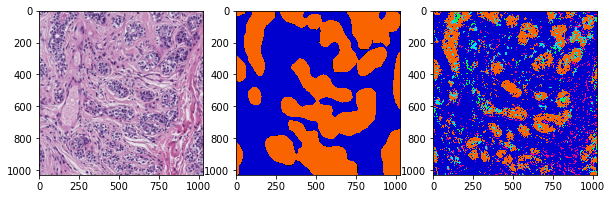

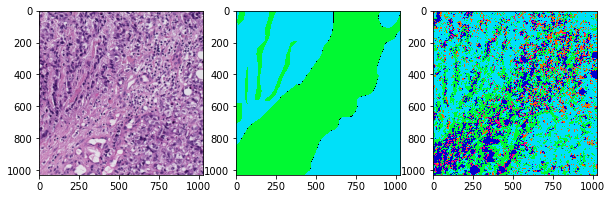

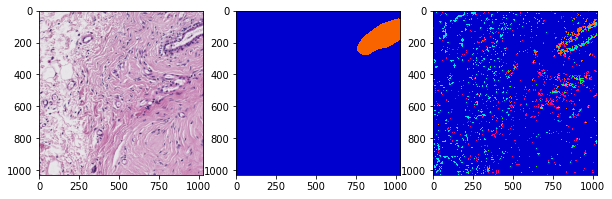

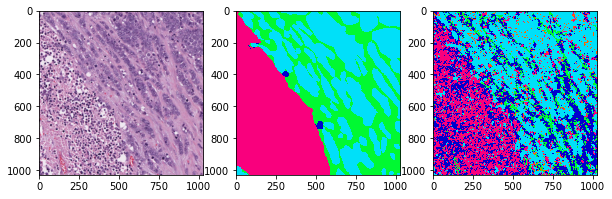

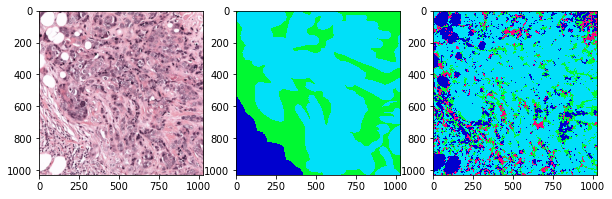

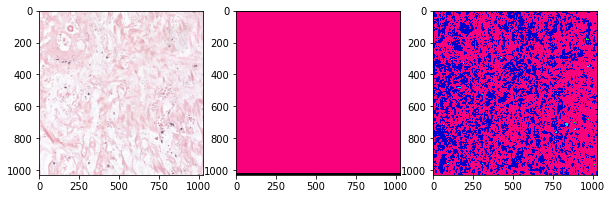

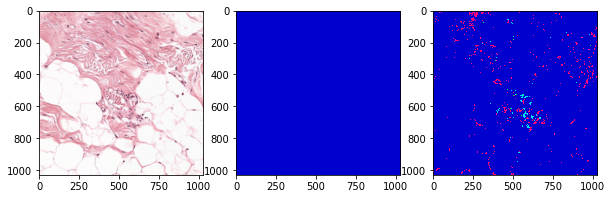

In [13]:
with create_batch_iterator(mode=mode, user_config=user_config, cpus=4) as training_iterator:
    for _ in range(7):
        x_batch, y_batch, info =  next(training_iterator)
        x_batch = list(x_batch.transpose(1,0,2,3,4))
        predictions = model.predict_on_batch(x_batch)
        patch = fit_data(x_batch[0][0], model._out_shape[:2])
        plot_inference(patch, y_batch[0][0], predictions[0])